In [1]:
import argparse
import logging.config
import os
from collections import defaultdict

from dotenv import load_dotenv

from rescueclip.logging_config import LOGGING_CONFIG

logging.config.dictConfig(LOGGING_CONFIG)
logger = logging.getLogger(__name__)
from pathlib import Path

import numpy as np
from typing import cast, Sequence, Literal
import weaviate
from tqdm import tqdm
from weaviate.classes.query import Filter, MetadataQuery
from weaviate.util import generate_uuid5, get_vector

from rescueclip import cuhk
from rescueclip.ml_model import (
    CollectionConfig,
    encode_image,
    CUHK_Apple_Collection,
    CUHK_Google_Siglip_Base_Patch16_224_Collection,
    CUHK_Google_Siglip_SO400M_Patch14_384_Collection,
    CUHK_laion_CLIP_ViT_bigG_14_laion2B_39B_b160k_Collection,
    CUHK_MetaCLIP_ViT_bigG_14_quickgelu_224_Collection,
    CUHK_ViT_B_32_Collection,
)
from rescueclip.weaviate import WeaviateClientEnsureReady

from pprint import pprint

from embed_cuhk import Metadata, embed_cuhk_dataset

load_dotenv()
QUERY_MAXIMUM_RESULTS = 200_000

INPUT_FOLDER = Path(os.environ["CUHK_PEDES_DATASET"]) / "out"
STOPS_FILE = Path("/scratch3/gbiss/images/CUHK-PEDES-OFFICIAL/caption_all.json")
sets = cuhk.get_sets_new(INPUT_FOLDER, STOPS_FILE)
sets = cuhk.keep_sets_containing_n_images(sets, 4)
number_of_images_in_sets = cuhk.get_number_of_images_in_sets(sets)

%load_ext autoreload
%autoreload 2

2025-02-24 21:51:37,693 [INFO] rescueclip.cuhk: After filtering, using 4649 sets and 18596 images


In [2]:
client = WeaviateClientEnsureReady().get_client()

2025-02-24 21:51:37,869 [INFO] rescueclip.weaviate: Weaviate is ready


In [3]:
from scipy.spatial.distance import pdist
import math

type SetMetrics = dict[int, np.ndarray]

def get_set_metrics_for_collection_config(collection_config: CollectionConfig, sets: cuhk.SetNumToImagesMap, number_of_images_in_sets: int, distance_metric: Literal["cosine"]) -> SetMetrics:
    collection = client.collections.get(collection_config.name)
    number_of_objects: int = collection.aggregate.over_all(total_count=True).total_count # type: ignore
    logger.info(f"Number of objects %s", number_of_objects)
    assert (
        number_of_objects <= QUERY_MAXIMUM_RESULTS 
    ), "Ensure docker-compose.yml has QUERY_MAXIMUM_RESULTS to greater than 200_000 or the experiment's results may be inaccurate"
    assert number_of_images_in_sets == number_of_objects, f"Number of images in sets is {cuhk.get_number_of_images_in_sets(sets)}, but should be {number_of_objects}"

    set_to_metrics: SetMetrics = {}
    for sett in tqdm(sets, desc=collection_config.name):
        images = sets[sett]
        images = collection.query.fetch_objects(
            filters=Filter.by_property("set_number").equal(sett),
            include_vector=True,
        ).objects
        assert len(images) == len(sets[sett]) == 4, f"Expected {len(sets[sett])} images but got {len(images)}"
        image_vectors = [image.vector["embedding"] for image in images]
        X = np.array(image_vectors)
        assert X.shape[0] == 4, f"Expected 4 rows but got {X.shape[0]}"
        
        if distance_metric == "cosine":
            # Compute cosine distances
            distances = pdist(X, metric='cosine')

            # Normalize distances
            # distances /=  2     # move the range of distances from [0, 2] to [0, 1]

        else:
            raise ValueError(f"Invalid distance metric {distance_metric}")
        
        
        assert distances.shape[0] == math.comb(len(sets[sett]), 2), f"Expected {math.comb(len(sets[sett]), 2)} distances but got {distances.shape[0]}"

        avg = np.mean(distances)
        std = np.std(distances)

        assert not np.isnan(avg), f"Average is NaN for {sett}"
        assert not np.isnan(std), f"Std is NaN for {sett}"

        set_to_metrics[sett] = distances
    
    return set_to_metrics


In [4]:
def get_set_metrics_for_pdna(
    sets: cuhk.SetNumToImagesMap,
    number_of_images_in_sets: int,
    distance_metric: Literal["cosine"] | Literal["euclidean"],
) -> SetMetrics:
    hashes_file = Path("/scratch3/atharva/photodna/hashes.csv")
    set_lookup_map = {
        filename: set_id for set_id, file_list in sets.items() for filename in file_list
    }

    # Get the PDNA hashes
    filename_to_hash_map, missing_filenames = cuhk.get_pdna_hashes(
        hashes_file, include_only=set(set_lookup_map.keys())
    )
    sets = cuhk.eliminate_sets_containing_files(filename_to_hash_map, missing_filenames, sets)
    set_lookup_map = {
        filename: set_id for set_id, file_list in sets.items() for filename in file_list
    }

    assert len(filename_to_hash_map) == len(
        set_lookup_map
    ), f"Some images are missing hashes, {len(filename_to_hash_map)} != {len(set_lookup_map)}"
    logger.info(f"Loaded {len(filename_to_hash_map)} hashes")

    set_to_metrics: SetMetrics = {}
    for sett in tqdm(sets, desc="PDNA"):
        file_names = sets[sett]
        image_vectors = [filename_to_hash_map[file_name] for file_name in file_names]
        X = np.array(image_vectors)
        assert X.shape[0] == 4, f"Expected 4 rows but got {X.shape[0]}"
        assert X.shape[1] == 144, f"Expected 144 cols but got {X.shape[1]}"

        # Normalize the vectors

        if distance_metric == "cosine":
            X = X / np.linalg.norm(X, axis=1, keepdims=True)
            distances = pdist(X, metric="cosine")
            # distances /= 2  # Normalize by the number of vectors to cut the range to [0, 1]
        elif distance_metric == "euclidean":
            distances = pdist(X, metric="euclidean")
            # Normalize by the number of vectors to cut the range to [0, 1]
            distances = distances / np.sqrt(144 * 255 ** 2)
        else:
            raise ValueError(f"Invalid distance_metric={distance_metric}")

        assert distances.shape[0] == math.comb(
            len(sets[sett]), 2
        ), f"Expected {math.comb(len(sets[sett]), 2)} distances but got {distances.shape[0]}"

        avg = np.mean(distances)
        std = np.std(distances)

        assert not np.isnan(avg), f"Average is NaN for {sett=}"
        assert not np.isnan(std), f"Std is NaN for {sett=}"

        set_to_metrics[sett] = distances

    return set_to_metrics

In [5]:
collection_configs = [CUHK_Apple_Collection, CUHK_ViT_B_32_Collection]

all_data: dict[str, SetMetrics] = {}

clip_distance_function = 'cosine'

for collection_config in collection_configs:
    set_to_metrics = get_set_metrics_for_collection_config(collection_config, sets, number_of_images_in_sets, clip_distance_function)
    all_data[collection_config.model_config.model_name + f' ({clip_distance_function})'] = set_to_metrics

2025-02-24 21:51:40,584 [INFO] __main__: Number of objects 18596


Apple_DFN5B_CLIP_ViT_H_14_384_CUHK: 100%|██████████| 4649/4649 [00:16<00:00, 284.92it/s]


2025-02-24 21:51:56,919 [INFO] __main__: Number of objects 18596


ViT_B_32_CUHK: 100%|██████████| 4649/4649 [00:12<00:00, 372.61it/s]


In [6]:
# PDNA
pdna_distance_function = 'cosine'
all_data[f'PhotoDNA ({pdna_distance_function})'] = get_set_metrics_for_pdna(sets, number_of_images_in_sets, pdna_distance_function)

2025-02-24 21:52:12,211 [INFO] __main__: Loaded 17224 hashes


PDNA: 100%|██████████| 4306/4306 [00:00<00:00, 20937.31it/s]


2025-02-24 21:52:12,738 [INFO] __main__: Plotting 3 models
2025-02-24 21:52:12,756 [INFO] __main__: Series mean: 0.15396770798561937
2025-02-24 21:52:12,761 [INFO] __main__: Series mean: 0.22782343407473338
2025-02-24 21:52:12,766 [INFO] __main__: Series mean: 0.2864864653113651


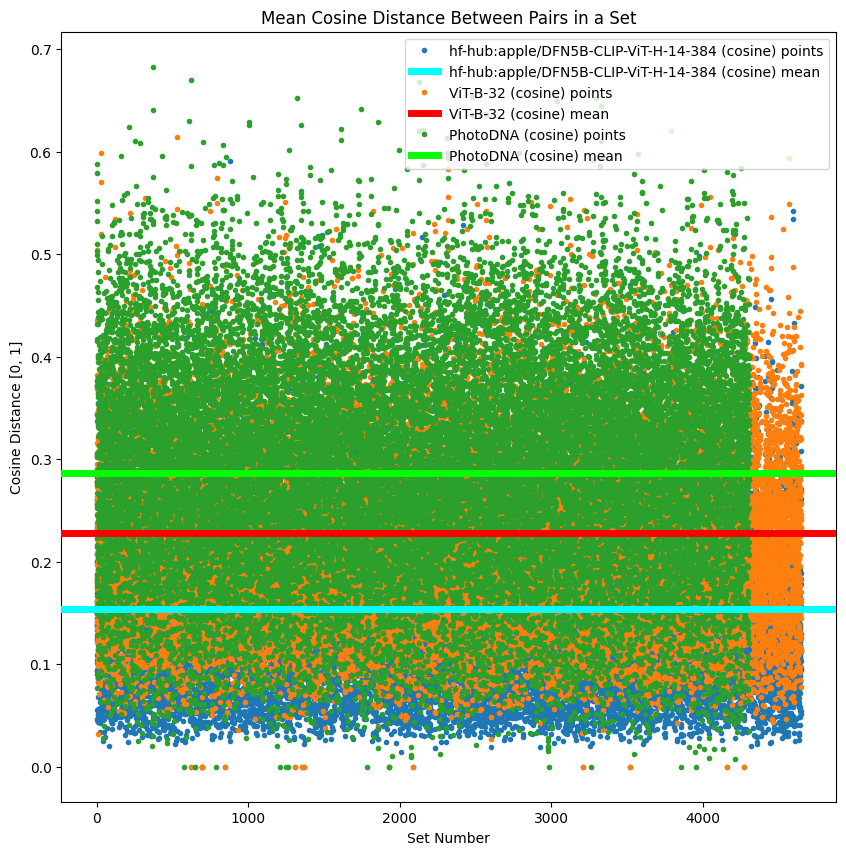

"\nHere's another (cool?) graph that computes the mean cosine distance between all pairs within a set, plots each set number on the x-axis, and plots those means on the y-axis (y-axis range is [0, 2]). The horizontal line for each model is the overall mean across all that model's points.\n\nWe can see the clear separation between two CLIP models (how they compare in the cosine distance between images within the same set)\n"

In [7]:
import matplotlib.pyplot as plt

# Choose a colormap to get distinct colors
num_plots = len(all_data)
logger.info(f"Plotting {num_plots} models")
colors = plt.get_cmap("tab10")  # Use a distinct color map
line_colors = ["cyan", "red", "lime", "purple"]  # Pick distinct colors


# Create the plot
plt.figure(figsize=(10, 10))
for i, (model_name, set_to_metrics) in enumerate(all_data.items()):
    cosine_distances = np.array([set_to_metrics[k] for k in set_to_metrics])
    x = np.tile(np.arange(len(set_to_metrics)).reshape(-1, 1), cosine_distances.shape[1]).flatten()
    y = cosine_distances.flatten()

    # Assign a distinct color from tab10
    dot_color = colors(i)

    # Plot the means as small dots.
    plt.plot(x, y, 'o', markersize=3, color=dot_color, label=f'{model_name} points', zorder=2)

    # Compute the overall mean for this series.
    series_mean = np.mean(y)

    logger.info(f"Series mean: {series_mean}")

    line_color = line_colors[i % len(line_colors)]

    # Plot a horizontal dashed line across the x-axis for this series mean.
    plt.axhline(
        y=float(series_mean),
        color=line_color,
        linestyle="-",
        linewidth=5,
        label=f"{model_name} mean",
        zorder=3,
    )


# Create an errorbar plot
plt.xlabel("Set Number")
if clip_distance_function == pdna_distance_function == 'cosine':
    plt.ylabel("Cosine Distance [0, 1]")
else:
    plt.ylabel("Distance [0, 1]")

plt.title("Mean Cosine Distance Between Pairs in a Set")
# plt.ylim(0, 2)  # Set y-axis limits between 0 and 2
plt.legend()
plt.show()

"""
Here's another (cool?) graph that computes the mean cosine distance between all pairs within a set, plots each set number on the x-axis, and plots those means on the y-axis (y-axis range is [0, 2]). The horizontal line for each model is the overall mean across all that model's points.

We can see the clear separation between two CLIP models (how they compare in the cosine distance between images within the same set)
"""

2025-02-24 22:03:01,401 [INFO] __main__: Plotting 3 models


2025-02-24 22:03:01,406 [INFO] __main__: Series mean: 0.15396770798561937
2025-02-24 22:03:01,423 [INFO] __main__: Series mean: 0.22782343407473338
2025-02-24 22:03:01,432 [INFO] __main__: Series mean: 0.2864864653113651


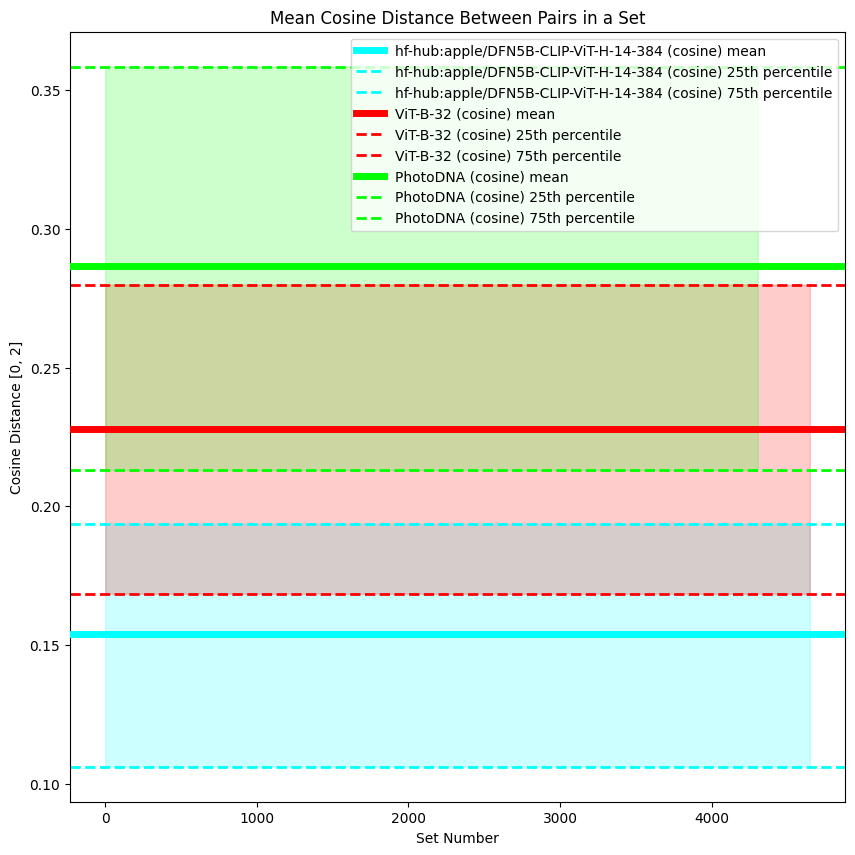

"\nHere's another (cool?) graph that computes the mean cosine distance between all pairs within a set, plots each set number on the x-axis, and plots those means on the y-axis (y-axis range is [0, 2]). The horizontal line for each model is the overall mean across all that model's points.\n\nWe can see the clear separation between two CLIP models (how they compare in the cosine distance between images within the same set)\n"

In [19]:
import matplotlib.pyplot as plt

# Choose a colormap to get distinct colors
num_plots = len(all_data)
logger.info(f"Plotting {num_plots} models")
colors = plt.get_cmap("tab10")  # Use a distinct color map
line_colors = ["cyan", "red", "lime", "purple"]  # Pick distinct colors


# Create the plot
plt.figure(figsize=(10, 10))
for i, (model_name, set_to_metrics) in enumerate(all_data.items()):
    cosine_distances = np.array([set_to_metrics[k] for k in set_to_metrics])
    x = np.tile(np.arange(len(set_to_metrics)).reshape(-1, 1), cosine_distances.shape[1]).flatten()
    y = cosine_distances.flatten()

    # Assign a distinct color from tab10
    dot_color = colors(i)

    # Plot the means as small dots.
    # plt.plot(x, y, 'o', markersize=3, color=dot_color, label=f'{model_name} points', zorder=2)

    # Compute the overall mean for this series.
    series_mean = np.mean(y)

    logger.info(f"Series mean: {series_mean}")

    line_color = line_colors[i % len(line_colors)]

    # Plot a horizontal dashed line across the x-axis for this series mean.
    plt.axhline(
        y=float(series_mean),
        color=line_color,
        linestyle="-",
        linewidth=5,
        label=f"{model_name} mean",
        zorder=3,
    )

    # Plot the 25th and 75th percentile bands as dashed lines
    # Compute percentiles
    y_10 = float(np.percentile(y, 25))  # 25th percentile
    y_90 = float(np.percentile(y, 75))  # 75th percentile
    plt.axhline(
        y=y_10,
        color=line_color,
        linestyle="dashed",
        linewidth=2,
        label=f"{model_name} 25th percentile",
        zorder=2,
    )
    plt.axhline(
        y=y_90,
        color=line_color,
        linestyle="dashed",
        linewidth=2,
        label=f"{model_name} 75th percentile",
        zorder=2,
    )
    plt.fill_between(x, y_10, y_90, color=line_color, alpha=0.2, zorder=1)


# Create an errorbar plot
plt.xlabel("Set Number")
if clip_distance_function == pdna_distance_function == 'cosine':
    plt.ylabel("Cosine Distance [0, 2]")
else:
    plt.ylabel("Distance [0, 2]")
plt.title("Mean Cosine Distance Between Pairs in a Set")
# plt.ylim(0, 2)  # Set y-axis limits between 0 and 2
plt.legend()
plt.show()

"""
Here's another (cool?) graph that computes the mean cosine distance between all pairs within a set, plots each set number on the x-axis, and plots those means on the y-axis (y-axis range is [0, 2]). The horizontal line for each model is the overall mean across all that model's points.

We can see the clear separation between two CLIP models (how they compare in the cosine distance between images within the same set)
"""

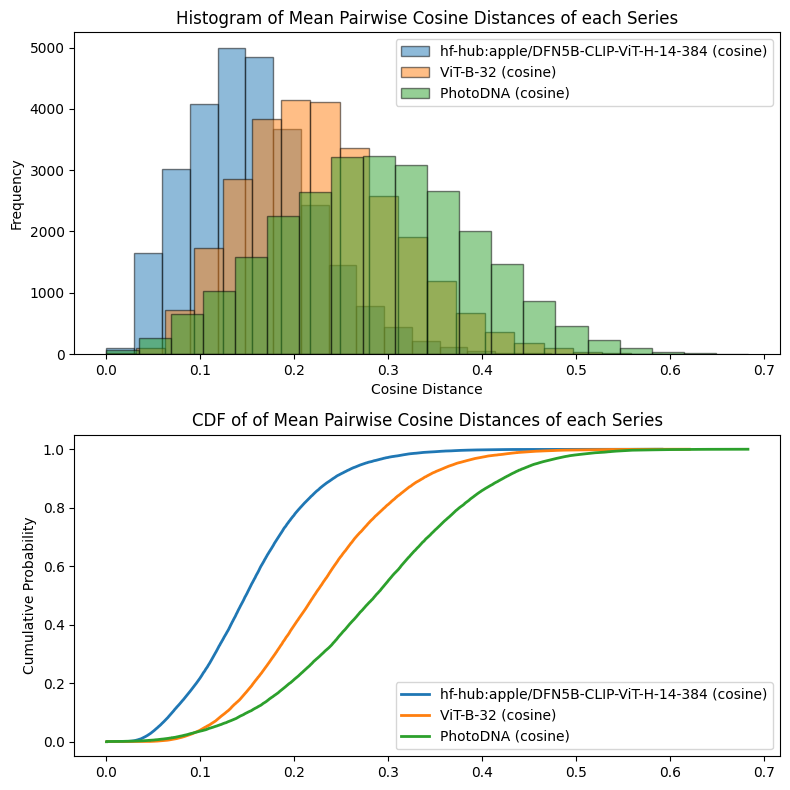

In [20]:
# Prepare a figure with two subplots: top=Histogram, bottom=CDF
fig, (ax_hist, ax_cdf) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex=False)

# Generate a color cycle or pick your own colors
colors = plt.get_cmap('tab10')  # or use e.g. ['blue', 'orange', 'green', ...]

for i, (model_name, set_to_metrics) in enumerate(all_data.items()):
    # Extract the values (first element of each tuple)
    cosine_distances = np.array([set_to_metrics[k] for k in set_to_metrics])
    values = cosine_distances.flatten()
    
    # 1) Plot the Histogram on the top subplot
    ax_hist.hist(
        values,
        bins=20,            # You can adjust the number of bins
        alpha=0.5,          # Transparency
        label=model_name,
        color=colors(i),
        edgecolor='black'
    )
    
    # 2) Compute and plot the CDF on the bottom subplot
    sorted_vals = np.sort(values)
    cdf_vals = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
    
    ax_cdf.plot(
        sorted_vals,
        cdf_vals,
        label=model_name,
        color=colors(i),
        linewidth=2
    )

# Configure histogram axis
ax_hist.set_title("Histogram of Mean Pairwise Cosine Distances of each Series")
ax_hist.set_xlabel("Cosine Distance")
ax_hist.set_ylabel("Frequency")
ax_hist.legend()

# Configure CDF axis
ax_cdf.set_title("CDF of of Mean Pairwise Cosine Distances of each Series")
if clip_distance_function == pdna_distance_function == 'cosine':
    plt.ylabel("Cosine Distance [0, 2]")
else:
    plt.ylabel("Distance [0, 2]")
ax_cdf.set_ylabel("Cumulative Probability")
ax_cdf.legend()

plt.tight_layout()
plt.show()

In [10]:
from scipy.spatial.distance import cdist

def get_set_metrics_for_collection_every_image_with_other_series(collection_config: CollectionConfig):
    collection = client.collections.get(collection_config.name)
    logger.info("Retrieving the entire database into memory")
    objects = collection.query.fetch_objects(
        limit=QUERY_MAXIMUM_RESULTS,
        include_vector=True,
        return_properties=True,
    ).objects
    assert len(objects) == 18596, "Expected the entire database to be retrieved"

    objects.sort(key=lambda obj: (obj.properties["set_number"], obj.properties["file_name"]))


    X = np.array([obj.vector["embedding"] for obj in objects])
    y_set_labels = np.array([obj.properties["set_number"] for obj in objects])
    logger.info(f"X.shape: {X.shape}")
    logger.info(f"y_set_labels.shape: {y_set_labels.shape}")

    distances = cdist(X, X, metric='cosine')

    def rolling_zero_matrix(n: int, window_size: int = 4) -> np.ndarray:
        """Creates an n x n matrix with a rolling window of zeros of size 'window_size'."""
        matrix = np.ones((n, n))  # Start with all ones
        for i in range(n):
            matrix[i, i:i+window_size] = 0  # Set a rolling window of zeros
        
        return matrix

    mask = rolling_zero_matrix(distances.shape[0])
    distances_masked = distances * mask
    distances_masked = distances_masked.flatten()
    print(f"distances_masked.shape: {distances_masked.shape}")
    distances_masked = distances_masked[distances_masked != 0]
    print(f"distances_masked.shape after removing zeros: {distances_masked.shape}")
    return distances_masked


In [11]:
def get_set_metrics_for_pdna_every_image_with_other_series(
    sets: cuhk.SetNumToImagesMap,
    number_of_images_in_sets: int,
    distance_metric: Literal["cosine"] | Literal["euclidean"],
) -> np.ndarray:
    hashes_file = Path("/scratch3/atharva/photodna/hashes.csv")
    set_lookup_map = {
        filename: set_id for set_id, file_list in sets.items() for filename in file_list
    }

    # Get the PDNA hashes
    filename_to_hash_map, missing_filenames = cuhk.get_pdna_hashes(
        hashes_file, include_only=set(set_lookup_map.keys())
    )
    sets = cuhk.eliminate_sets_containing_files(filename_to_hash_map, missing_filenames, sets)
    set_lookup_map = {
        filename: set_id for set_id, file_list in sets.items() for filename in file_list
    }

    filename_hash_pairs = list(filename_to_hash_map.items())
    filename_hash_pairs.sort(key=lambda x: (set_lookup_map[x[0]], x[0]))
    hashes = [hash for fn, hash in filename_hash_pairs]

    X = np.array(hashes)
    logger.info(f"X.shape: {X.shape}")

    if distance_metric == "cosine":
        X = X / np.linalg.norm(X, axis=1, keepdims=True)
        distances = cdist(X, X, metric="cosine")
        distances /= 2  # Normalize by the number of vectors to cut the range to [0, 1]
    elif distance_metric == "euclidean":
        distances = cdist(X, X, metric="euclidean")
        # Normalize by the number of vectors to cut the range to [0, 1]
        distances = distances / np.sqrt(144 * 255 ** 2)
    else:
        raise ValueError(f"Invalid distance_metric={distance_metric}")

    def rolling_zero_matrix(n: int, window_size: int = 4) -> np.ndarray:
        """Creates an n x n matrix with a rolling window of zeros of size 'window_size'."""
        matrix = np.ones((n, n))  # Start with all ones
        for i in range(n):
            matrix[i, i:i+window_size] = 0  # Set a rolling window of zeros
        
        return matrix

    mask = rolling_zero_matrix(distances.shape[0])
    distances_masked = distances * mask
    distances_masked = distances_masked.flatten()
    print(f"distances_masked.shape: {distances_masked.shape}")
    distances_masked_no_zeros = distances_masked[distances_masked != 0]
    print(f"distances_masked.shape after removing zeros: {distances_masked_no_zeros.shape}")
    print(f"difference: {distances_masked.shape[0] - distances_masked_no_zeros.shape[0]}")
    return distances_masked_no_zeros

In [ ]:
from typing import Optional


def plot_histogram(
    pairwise_distances_flat: np.ndarray,
    collection_config: Optional[CollectionConfig] = None,
    pdna_dict_key: Optional[str] = None,
    color_index: int = 0,
):
    # Prepare a figure with two subplots: top=Histogram, bottom=CDF
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), sharex="row")

    (ax_hist1, ax_hist2), (ax_cdf1, ax_cdf2) = axes

    # Generate a color cycle or pick your own colors
    colors = plt.get_cmap("tab10")  # or use e.g. ['blue', 'orange', 'green', ...]

    if collection_config is not None:
        data = [
            (
                collection_config.model_config.model_name + " Same Series",
                np.array(
                    [
                        all_data[collection_config.model_config.model_name + " (cosine)"][k]
                        for k in set_to_metrics
                    ]
                ).flatten(),
            ),
            (collection_config.model_config.model_name + " Different Series", pairwise_distances_flat),
        ]
    elif pdna_dict_key is not None:
        data = [
            (pdna_dict_key, np.array(
                    [
                        all_data[pdna_dict_key][k]
                        for k in set_to_metrics
                    ]
                ).flatten(),
            ),
            (pdna_dict_key, pairwise_distances_flat),
        ]
    else:
        raise ValueError("Either collection_config or pdna_dict_key must be provided")

    values = np.array(data[0][1])

    print(data[0][0])

    # 1) Plot the Histogram on the top left subplot
    ax_hist1.hist(
        values,
        bins=20,  # You can adjust the number of bins
        alpha=0.5,  # Transparency
        label=data[0][0],
        color=colors(color_index),
        edgecolor="black",
    )

    # Configure histogram axis
    ax_hist1.set_title("Histogram of Mean Pairwise Cosine Distances of Same Series")
    ax_hist1.set_xlabel("Cosine Distance [0, 2]")
    ax_hist1.set_ylabel("Frequency")
    ax_hist1.legend(loc='upper right')

    # 2) Compute and plot the CDF on the bottom left subplot
    sorted_vals = np.sort(values)
    cdf_vals = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)

    ax_cdf1.plot(sorted_vals, cdf_vals, label=data[0][0], color=colors(color_index), linewidth=2)

    # Configure CDF axis
    ax_cdf1.set_title("CDF of of Mean Pairwise Cosine Distances of Same Series")
    if clip_distance_function == pdna_distance_function == "cosine":
        plt.ylabel("Cosine Distance [0, 2]")
    else:
        plt.ylabel("Distance [0, 1]")
    ax_cdf1.set_ylabel("Cumulative Probability")
    ax_cdf1.legend(loc='upper right')

    values = np.array(data[1][1])

    # 1) Plot the Histogram on the top right subplot
    ax_hist2.hist(
        values,
        bins=20,  # You can adjust the number of bins
        alpha=0.5,  # Transparency
        label=data[1][0],
        color=colors(color_index),
        edgecolor="black",
    )

    # Configure histogram axis
    ax_hist2.set_title("Histogram of Mean Pairwise Cosine Distances of Different Series")
    ax_hist2.set_xlabel("Cosine Distance [0, 2]")
    ax_hist2.set_ylabel("Frequency")
    ax_hist2.legend(loc='upper right')

    # 2) Compute and plot the CDF on the bottom right subplot
    sorted_vals = np.sort(values)
    cdf_vals = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)

    ax_cdf2.plot(sorted_vals, cdf_vals, label=data[1][0], color=colors(color_index), linewidth=2)

    # Configure CDF axis
    ax_cdf2.set_title("CDF of of Mean Pairwise Cosine Distances of Different Series")
    if clip_distance_function == pdna_distance_function == "cosine":
        plt.ylabel("Cosine Distance [0, 2]")
    else:
        plt.ylabel("Distance [0, 1]")
    ax_cdf2.set_ylabel("Cumulative Probability")
    ax_cdf2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [13]:
collection_config = CUHK_Apple_Collection
all_pairs_distances = get_set_metrics_for_collection_every_image_with_other_series(collection_config)
all_pairs_distances.shape

2025-02-24 21:52:14,292 [INFO] __main__: Retrieving the entire database into memory
2025-02-24 21:52:18,126 [INFO] __main__: X.shape: (18596, 1024)
2025-02-24 21:52:18,127 [INFO] __main__: y_set_labels.shape: (18596,)
distances_masked.shape: (345811216,)
distances_masked.shape after removing zeros: (345736822,)


(345736822,)

hf-hub:apple/DFN5B-CLIP-ViT-H-14-384 Same Series


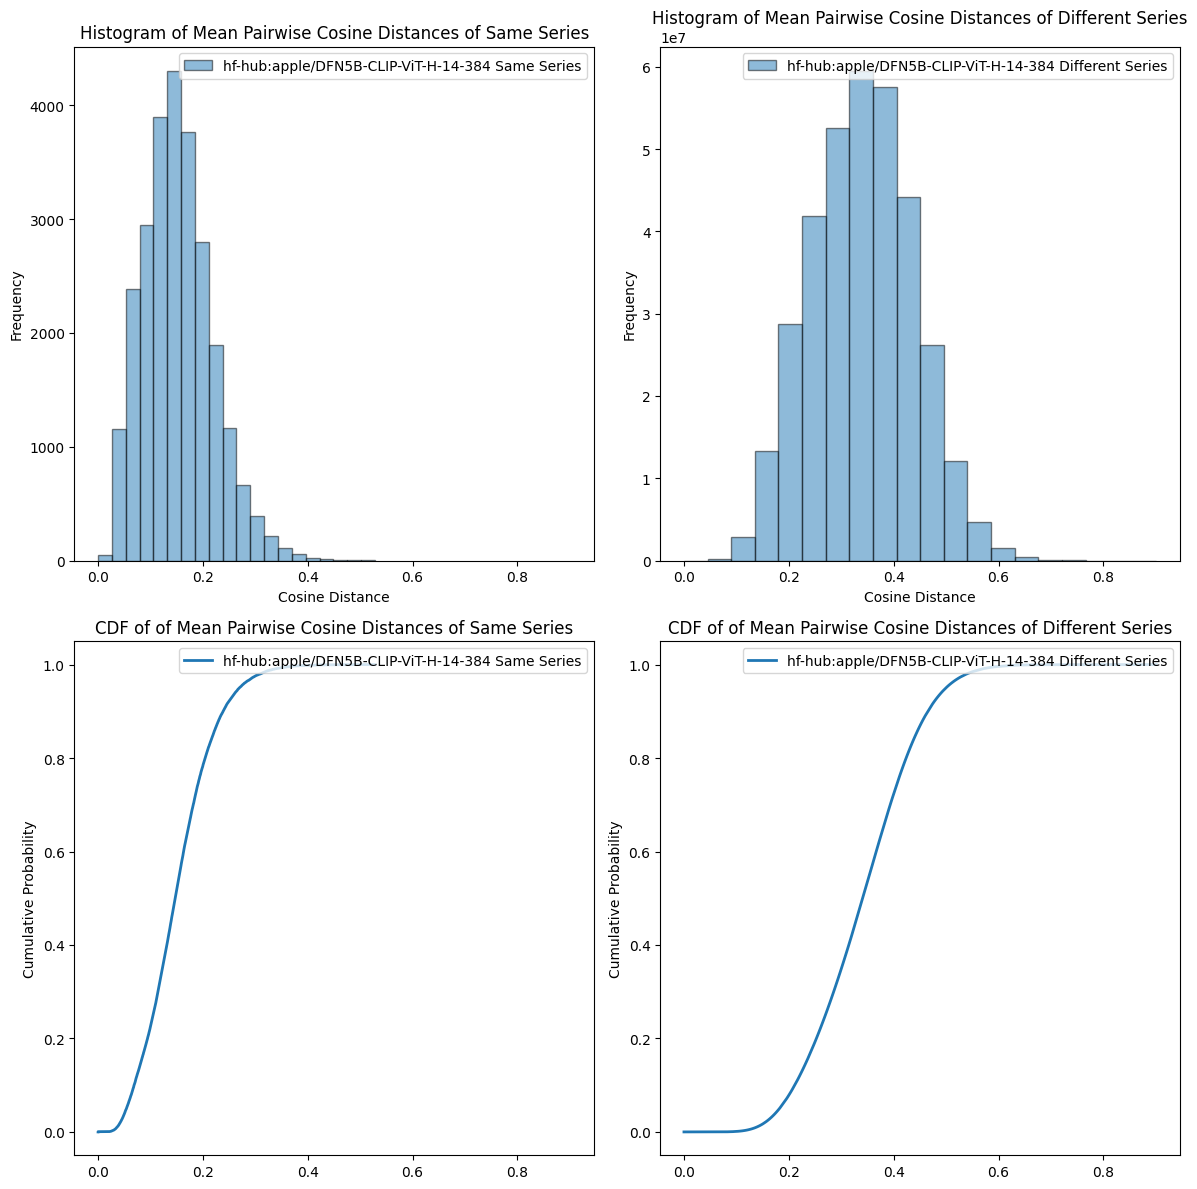

In [14]:
plot_histogram(all_pairs_distances, collection_config, None, 0)

In [15]:
collection_config = CUHK_ViT_B_32_Collection
all_pairs_distances = get_set_metrics_for_collection_every_image_with_other_series(collection_config)
print(all_pairs_distances.shape)

2025-02-24 21:58:14,948 [INFO] __main__: Retrieving the entire database into memory


2025-02-24 21:58:16,839 [INFO] __main__: X.shape: (18596, 512)
2025-02-24 21:58:16,840 [INFO] __main__: y_set_labels.shape: (18596,)
distances_masked.shape: (345811216,)
distances_masked.shape after removing zeros: (345736826,)
(345736826,)


ViT-B-32 Same Series


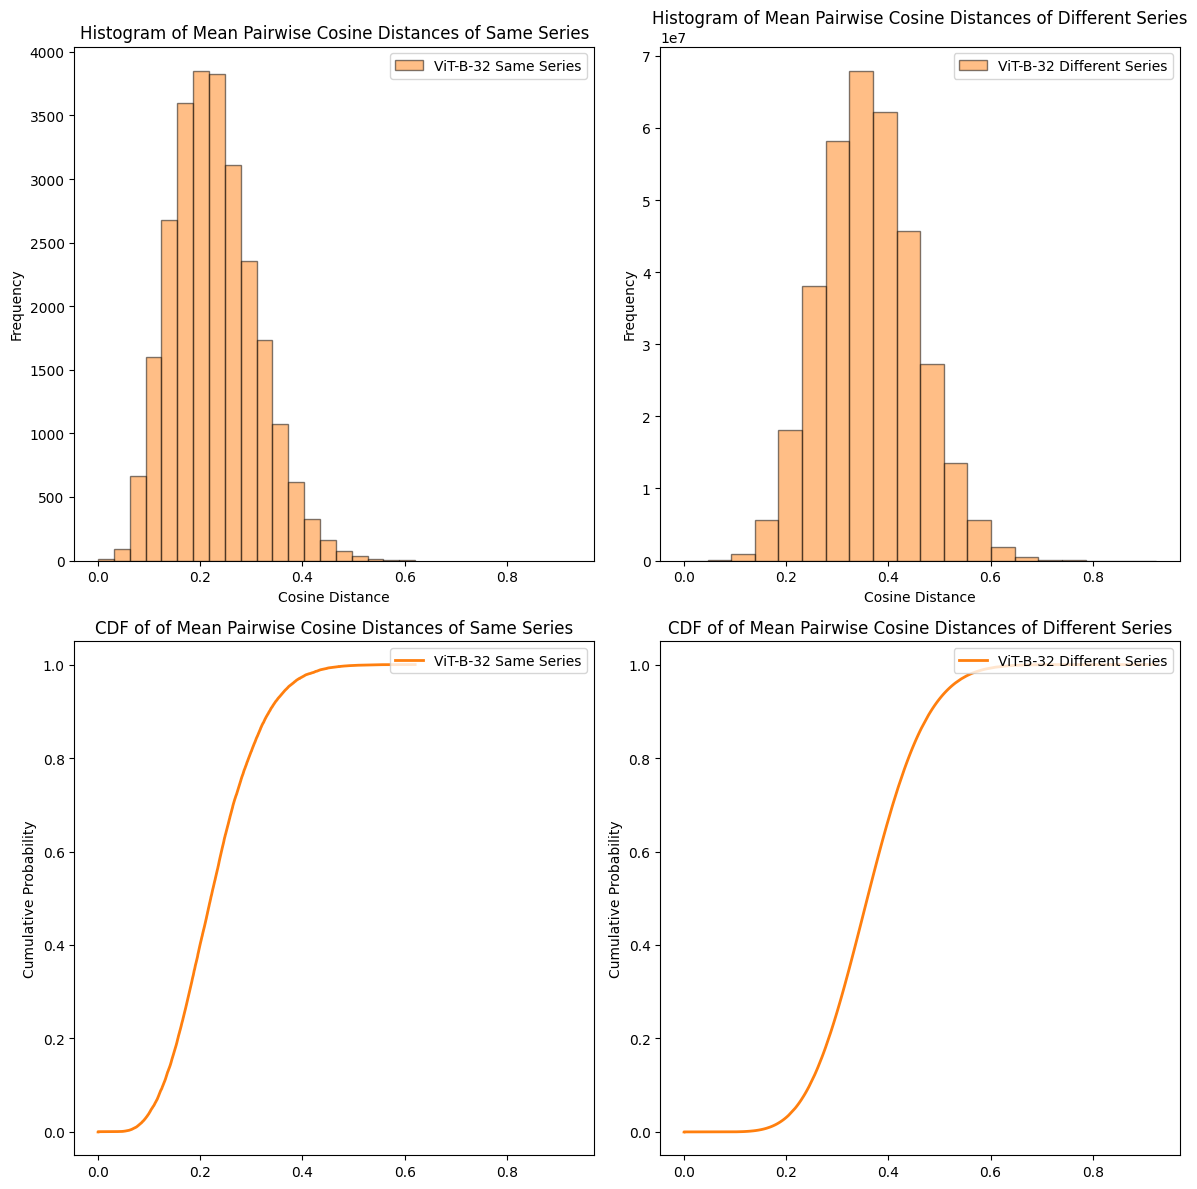

In [16]:
plot_histogram(all_pairs_distances, collection_config, None, 1)

In [17]:
all_pairs_distances  = get_set_metrics_for_pdna_every_image_with_other_series(sets, number_of_images_in_sets, 'cosine')
all_pairs_distances.shape

2025-02-24 22:01:44,397 [INFO] __main__: X.shape: (17224, 144)
distances_masked.shape: (296666176,)
distances_masked.shape after removing zeros: (296597269,)
difference: 68907


(296597269,)

PhotoDNA (cosine)


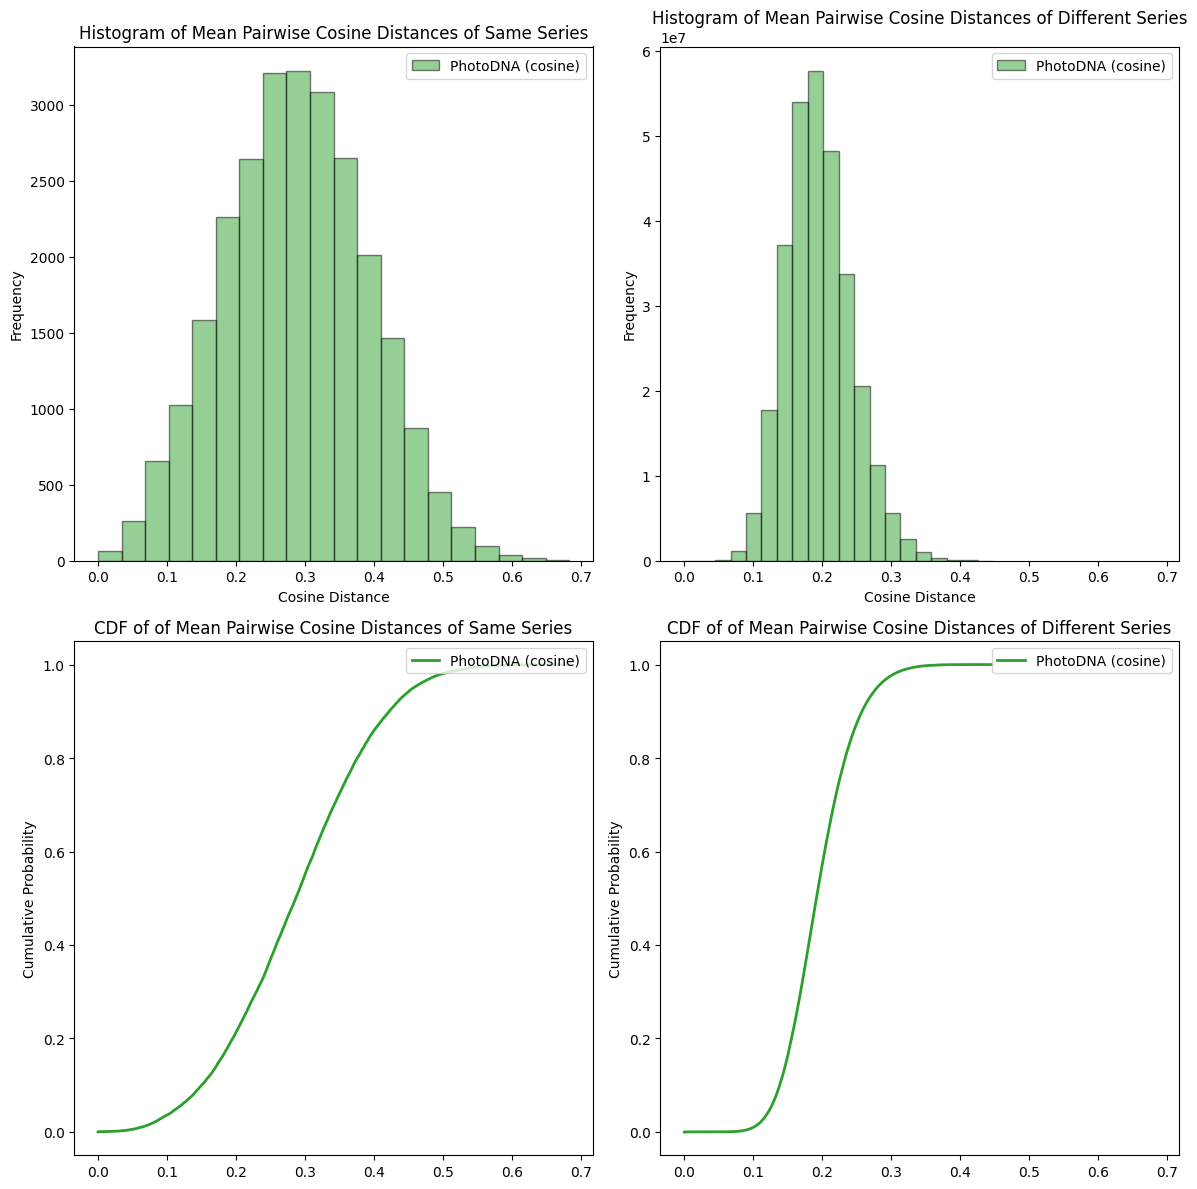

In [18]:
plot_histogram(all_pairs_distances, None, f'PhotoDNA ({pdna_distance_function})', 2)
